In [1]:
# !pip install accelerate -U
!pip install transformers[torch]

# Requirements

- transformer: hugginface transformers
- datasets: klue dataset load
- evaluate: 데이터셋 evaluate

In [2]:
!pip install transformers

In [3]:
#  Python 프로그램에서 데이터셋을 쉽게 다룰 수 있게 해주는 datasets 라이브러리를 설치하는 작업
!pip install datasets

In [4]:
!pip install evaluate

# Import

In [5]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer # baseline code용 tfidef vectorirzer(또는 tokenizer)
from sklearn import preprocessing
from sklearn.metrics import f1_score
from IPython.display import display, HTML

from transformers import AutoModel, AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer # 사용하고자 하는 모델, 토크나이저 적용시 필요
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, ClassLabel

from tqdm.auto import tqdm # process bar 표시용

import warnings
warnings.filterwarnings(action='ignore')

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device  # pt 코드에서 필요함

device(type='cuda')

# Data Load

- klue 데이터셋에서 연합뉴스 토픽 분류 라벨링 된 데이터(TC a.k.a ynat)


In [7]:
# Hugging Face의 datasets 라이브러리를 사용하여 "klue"의 "ynat" 데이터셋을 불러와 datasets라는 변수에 저장
datasets = load_dataset("klue", "ynat") # "klue" 데이터셋에서 "ynat" 부분집합을 불러오기

In [8]:
# 데이터셋 내에 어떻게 들어있나 보기 위한 함수

# 임의의 예제를 선택하여 출력하는 함수를 정의
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."

    picks = []

    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)

        # 이미 등록된 예제가 뽑힌 경우, 다시 추출
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)

        picks.append(pick)

    # 임의로 추출된 인덱스들로 구성된 데이터 프레임 선언
    df = pd.DataFrame(dataset[picks])

    for column, typ in dataset.features.items():
        # 라벨 클래스를 스트링으로 변환
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])

    display(HTML(df.to_html()))

show_random_elements(datasets["validation"])

,guid,title,label,url,date
0,ynat-v1_dev_08299,모멘트 기자회견 하다 제지받는 민주노총 조합원들,정치,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=102&sid2=251&oid=001&aid=0012067881,2020.12.08. 오후 6:00
1,ynat-v1_dev_00896,SF소설 현실세계의 어두운 단면을 비추다,생활문화,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009481157,2017.08.17. 오후 4:24
2,ynat-v1_dev_05807,응암동 백련산 SK뷰 아이파크 청약경쟁률 5.6대 1,경제,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=261&oid=001&aid=0009094745,2017.03.09. 오후 2:48
3,ynat-v1_dev_07534,한국전력공사 1분기 영업이익 4천306억원…3년만에 흑자종합,경제,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=258&oid=001&aid=0011611126,2020.05.15. 오전 11:36
4,ynat-v1_dev_01949,보성군 공무원 근로자의 날에 특별휴가…노조 건의 수용,사회,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=102&sid2=251&oid=001&aid=0011572227,2020.04.26. 오후 2:32
5,ynat-v1_dev_03658,경기도시공사 임대주택 경비·미화원 휴게실 지상으로,사회,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=260&oid=001&aid=0011570527,2020.04.24. 오후 5:24
6,ynat-v1_dev_00872,2천500조원을 어찌하오리까…유럽은행들 싼 보관법 궁리,세계,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=258&oid=001&aid=0008619802,2016.08.17. 오후 12:25
7,ynat-v1_dev_06749,수도권 코로나19 확산 비상,사회,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=102&sid2=257&oid=001&aid=0011642127,2020.05.29. 오전 9:07
8,ynat-v1_dev_03269,전남대 용봉학술상 이상준·함유근 교수,사회,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=102&sid2=250&oid=001&aid=0011673797,2020.06.12. 오전 11:45
9,ynat-v1_dev_02279,특징주 알비케이이엠디 최대주주 변경에 강세,경제,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=258&oid=001&aid=0010135633,2018.06.08. 오전 9:18


# Model Load

In [9]:
pretrained_model = 'monologg/kobigbird-bert-base'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

In [10]:
test_model = AutoModel.from_pretrained(pretrained_model)
test_model

BigBirdModel(
  (embeddings): BigBirdEmbeddings(
    (word_embeddings): Embedding(32500, 768, padding_idx=0)
    (position_embeddings): Embedding(4096, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BigBirdEncoder(
    (layer): ModuleList(
      (0-11): 12 x BigBirdLayer(
        (attention): BigBirdAttention(
          (self): BigBirdBlockSparseAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): BigBirdSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
    

In [11]:
sentences = ["안녕하세요 hmkd 여러분", "무더운 여름에 건강관리 잘하세요!"]
features = tokenizer(
    sentences,
    max_length=10,
    padding="max_length",
    truncation=True,
)
features

{'input_ids': [[2, 9279, 4681, 9421, 576, 4522, 4507, 4565, 8280, 3], [2, 26787, 7775, 4584, 7206, 11066, 3747, 4681, 9421, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [12]:
features.items()

dict_items([('input_ids', [[2, 9279, 4681, 9421, 576, 4522, 4507, 4565, 8280, 3], [2, 26787, 7775, 4584, 7206, 11066, 3747, 4681, 9421, 3]]), ('token_type_ids', [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), ('attention_mask', [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])])

In [13]:
features = {k:torch.tensor(v) for k,v in features.items()}
output_tensor=test_model(**features)
print(output_tensor)

Attention type 'block_sparse' is not possible if sequence_length: 10 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0085,  0.3430, -0.4673,  ...,  0.1736, -0.2570,  0.0558],
         [ 0.4125, -0.6818, -0.1634,  ...,  0.0846,  0.1364,  0.4318],
         [ 0.4620,  0.0325,  0.0777,  ...,  0.1734,  0.0707,  0.1572],
         ...,
         [-0.2735,  0.2188,  0.1350,  ..., -0.2034,  0.2622,  0.4731],
         [ 0.1283,  0.2342, -0.3019,  ..., -0.2352,  0.1830,  0.6579],
         [-0.0145,  0.0533,  0.2154,  ..., -0.1981, -0.0600,  0.3875]],

        [[ 0.3253, -0.0567, -0.1669,  ...,  0.0151,  0.3085,  0.1041],
         [ 0.0719, -0.0903,  0.0267,  ..., -0.2625,  0.7100,  0.1628],
         [-0.0882, -0.0213, -0.1715,  ..., -0.1045,  0.8717,  0.2090],
         ...,
         [ 0.1878, -0.0069, -0.2244,  ...,  0.2413,  0.4385, -0.0058],
         [ 0.1836, -0.0750,  0.2445,  ...,  0.2398,  0.3535, -0.1645],
         [-0.1313, -0.2876, -0.0321,  ..., -0.2087,  0.4650,  0.2791]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_ou

In [14]:
# output_tensor가 텐서가 아니라 사전 또는 다른 구조인 경우(복잡한 모델을 처리할 때 자주 발생할 수 있음) 관심 있는 특정 텐서에 먼저 액세스해야 함
for key, value in output_tensor.items():
    print(f"Size of tensor '{key}': {value.size()}")

Size of tensor 'last_hidden_state': torch.Size([2, 10, 768])
Size of tensor 'pooler_output': torch.Size([2, 768])


#### 모델링 위한 datasets 토큰화

In [10]:
# 데이터 tokenize
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True,  return_token_type_ids=False,) # 토큰의 타입 정보를 반환하지 않도록 함
# preprocess_function은 데이터셋의 각 예제에 대해 토큰화 작업을 수행하고, 토큰화된 결과를 새로운 데이터셋에 저장. batched=True로 설정되어 있으므로, preprocess_function은 여러 예제를 동시에 처리
tokenized_datasets = datasets.map(preprocess_function, batched=True)


Map:   0%|          | 0/45678 [00:00<?, ? examples/s]

In [11]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'attention_mask'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'attention_mask'],
        num_rows: 9107
    })
})

In [12]:
# loss type define
import evaluate
accuracy = evaluate.load("accuracy")

In [13]:
# 기사의 본문을 입력으로 받아서 해당 기사가 7개 topic중 어느 것에 속하는지를 분류
# loss(accuracy) 적용
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "IT과학", 1: "경제", 2: "사회", 3: "생활문화", 4: "세계", 5:"스포츠", 6: "정치" }
label2id = {"IT과학":0, "경제":1, "사회":2, "생활문화":3, "세계":4, "스포츠":5, "정치":6 }

# model define

- AutoModelForSequenceClassification.from_pretrained : 이용하면 쉽게 모델 정의가능

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=7, id2label=id2label, label2id=label2id)

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model

BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(32500, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Argument set & Run

- 여기서 모델에 쓰이는 parameter정의
- 만들어진 모델은 huggingface에(온라인) 저장한 후 불러올 수 있음
- 불러와서 사용할때 pipline으로 사용 가능

In [16]:
training_args = TrainingArguments(
    output_dir="topic_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Attention type 'block_sparse' is not possible if sequence_length: 18 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.374800,0.382304,0.869331


TrainOutput(global_step=2855, training_loss=0.46627645409044577, metrics={'train_runtime': 328.3099, 'train_samples_per_second': 139.131, 'train_steps_per_second': 8.696, 'total_flos': 495932362009212.0, 'train_loss': 0.46627645409044577, 'epoch': 1.0})

In [17]:
trainer.evaluate()

{'eval_loss': 0.38230443000793457,
 'eval_accuracy': 0.8693312836279785,
 'eval_runtime': 15.0501,
 'eval_samples_per_second': 605.114,
 'eval_steps_per_second': 37.874,
 'epoch': 1.0}

In [18]:
# Save the model manually
# config.json 및 pytorch_model.bin 파일이 "my_model" 디렉토리에 생성
model.save_pretrained("topic_model")

# 문장 하나에 적용

In [ ]:
text ='국회, 2월 임시회 개회…6~8일 대정부질문 여야 주자는?'
inputs =  tokenizer(text, truncation=True,  return_token_type_ids=False, return_tensors="pt").to(device)
model.eval() # 모델을 평가 모드로 설정
outputs = model(**inputs)
predictions = outputs.logits.argmax(-1) # argmax(-1)는 마지막 차원(일반적으로 클래스 차원)을 따라 가장 큰 값의 인덱스를 반환
id2label[predictions.cpu().numpy()[0]] # 예측된 클래스 인덱스를 넘파이 배열로 변환하고 그 주 첫번째 값을 레이블로 변경

'정치'

In [ ]:
!mkdir /content/drive/MyDrive/hmkd1/강의/nlp/best_model

In [19]:
!ls

drive  sample_data  topic_model


In [20]:
!cp -r ./topic_model ./drive/MyDrive/hmkd1/강의/nlp/best_model

# 대회 데이터에 적용해보기

In [ ]:
!mkdir /content/drive/MyDrive/project_task/AI한글교육솔루션/foreigners/task1

mkdir: cannot create directory ‘/content/drive/MyDrive/project_task/AI한글교육솔루션/foreigners/task1’: File exists


In [ ]:
path = '/content/drive/MyDrive/project_task/AI한글교육솔루션/foreigners/[참고자료] 문장 유형 분류 AI 경진대회/open'
mypath = '/content/drive/MyDrive/project_task/AI한글교육솔루션/foreigners/task1'

In [ ]:
df = pd.read_csv(path +'/train.csv')

In [ ]:
df.head()

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [ ]:
df['분류'] = ''
for i in tqdm(range(len(df))):
  inputs = tokenizer(df["문장"][i], truncation=True,  return_token_type_ids=False,return_tensors="pt").to(device)
  outputs = model(**inputs)
  predictions = outputs.logits.argmax(-1)
  df['분류'][i] = id2label[predictions.cpu().numpy()[0]]

  0%|          | 0/16541 [00:00<?, ?it/s]

In [ ]:
df[['문장','분류']]

,문장,분류
0,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,경제
1,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사회
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,경제
3,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사회
4,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사회
...,...,...
16536,"＇신동덤＇은 ＇신비한 동물사전＇과 ＇해리 포터＇ 시리즈를 잇는 마법 어드벤처물로, ...",생활문화
16537,"수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목, 어깨, 팔꿈치, ...",생활문화
16538,김금희 소설가는 ＂계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 ...,생활문화
16539,1만명이 넘는 방문자수를 기록한 이번 전시회는 총 77개 작품을 넥슨 사옥을 그대로...,생활문화


['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']

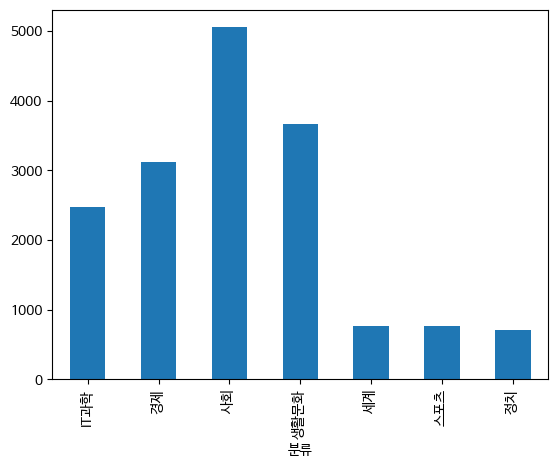

In [ ]:
df.groupby('분류').분류.count().plot(kind = 'bar')
list(id2label.values())

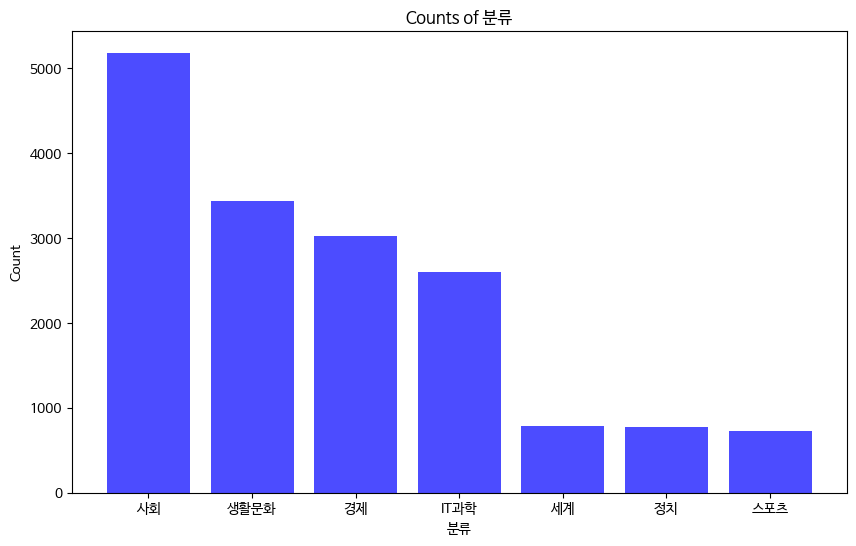

['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']

In [ ]:
# Assuming that 'df' is a pandas DataFrame and 'id2label' is a dictionary
# The following example code generates a bar plot using matplotlib.

import matplotlib.pyplot as plt

# Group the data by '분류' column and count the number of each group
counts = df['분류'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color='blue', alpha=0.7)

# Set the title and labels
plt.title('Counts of 분류')
plt.xlabel('분류')
plt.ylabel('Count')

# Show the plot
plt.show()

# To get a list of values from 'id2label' dictionary
labels = list(id2label.values())
labels

